# Setup

In [17]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess = tf.InteractiveSession()

# MNIST

MNIST is a database of handwritten digits. The images are 28x28 greyscale images (encoded as 784-dimensional vectors in row-major order). There are 60,000 images in the training set, and there are 10,000 images in the test set.

Why is there a train-test split? We care about how our function generalizes, and so we want to benchmark its performance on a set of data that it hasn't seen before. Otherwise, a "perfect" learning algorithm could just memorize all the data points, but this algorithm wouldn't generalize well.

Let's see what one of the MNIST images looks like.

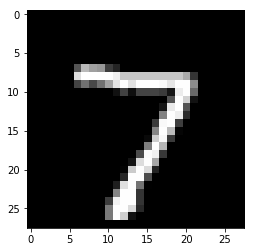

In [4]:
plt.imshow(mnist.test.images[0].reshape(28, 28), cmap='gray')

Let's check the label of this image. The MNIST labels are encoded in one-hot format. There are 10 possible labels, and the vector with label $i$ is the $i$-dimensional vector that has the entry $1$ in the $i$th position and $0$s elsewhere.

In [5]:
mnist.test.labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [6]:
np.argmax(mnist.test.labels[0])

7

# Fully-connected neural network

Let's design a fully-connected neural network to classify MNIST digits. It should take a 784-dimensional input and give a 10-dimensional one-hot encoded probability distribution as output.

In [7]:
x = tf.placeholder(tf.float32, (None, 28*28)) # batch of inputs
y_ = tf.placeholder(tf.float32, (None, 10)) # batch of corresponding labels

In [48]:
# this corresponds with the model of a neuron in [ 02-01-notes ]
# except this is describing an entire layer, not a single neuron
# and we're not including the activation function inside here

from scipy.special import expit as sigmoid

def fully_connected(x, input_dimension, output_dimension):
    w = tf.Variable(tf.random_normal((input_dimension, output_dimension)))
    b = tf.Variable(tf.random_normal((output_dimension,)))

    # return sigmoid(tf.matmul(x, w) + b)
    return tf.matmul(x, w) + b

Let's start with a really simple neural network with only one fully-connected layer (the output layer) with 10 neurons.

See [ 02-04-notes ] for an architecture diagram.

In [49]:
# TODO
y = fully_connected(x, int(x.shape[1]), 10)

Above, $y$ is a 10-dimensional vector, but it's not a probability distribution. We can fix that by applying the softmax function to the logits $y$:

$$\sigma(y)_i = \frac{e^{y_i}}{\sum_j e^{y_j}}$$

And we can define loss as the cross entropy between the true probability distribution (the labels) $p$ and the predicted probability distribution $q$:

$$H(p, q) = - \sum_i p(x) \log q(x)$$

In TensorFlow, we can do both of these in a single step (also needed for numerical stability):

In [50]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

In [30]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

We have 60000 training points, so we'll be doing minibatch stochastic gradient descent to train our network (instead of computing gradients over all 60000 data points).

In [41]:
BATCH_SIZE = 100
ITERATIONS = 1000

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    sess.run(optimizer, {x: x_batch, y_: y_batch})

## Evaluation

Let's evaluate the accuracy of our network over the test set.

In [42]:
def accuracy(predictions, labels):
    return np.mean(np.argmax(predictions, 1) == np.argmax(labels, 1))

In [43]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.9006

# Deep fully-connected network

Will adding a ton of parameters help us find a better solution? Let's use a deep fully-connected network using layers with 2000, 1000, and 100 neurons in the hidden layers and then 10 neurons in the output layer. Let's use ReLU activation for all the hidden layers. See [ 02-05-notes ] for an architecture diagram.

In [52]:
# TODO
fc1 = tf.nn.relu(fully_connected(x, 784, 2000))
fc2 = tf.nn.relu(fully_connected(fc1, 2000, 1000))
fc3 = tf.nn.relu(fully_connected(fc2, 1000, 100))
fc4 = fully_connected(fc3, 100, 10)

y = fc4

Our initial network had ~8,000 parameters. The above network has ~3.5 million parameters, which is over 400x the capacity of the first one.

In [53]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

Let's use a fancier optimizer this time.

In [54]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [55]:
BATCH_SIZE = 50
ITERATIONS = 5000 # this takes ~ 2 minutes on my laptop

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    l, _ = sess.run([loss, optimizer], {x: x_batch, y_: y_batch})
    if (i+1) % 100 == 0:
        print('iteration %d, batch loss %f' % (i+1, np.mean(l)))

iteration 100, batch loss 2169.350586
iteration 200, batch loss 3078.282471
iteration 300, batch loss 1777.353271
iteration 400, batch loss 2797.853760
iteration 500, batch loss 744.652100
iteration 600, batch loss 1401.535034
iteration 700, batch loss 682.831726
iteration 800, batch loss 1088.304321
iteration 900, batch loss 837.428223
iteration 1000, batch loss 1219.963379
iteration 1100, batch loss 20.649609
iteration 1200, batch loss 593.458252
iteration 1300, batch loss 121.415428
iteration 1400, batch loss 0.000000
iteration 1500, batch loss 481.883667
iteration 1600, batch loss 538.229126
iteration 1700, batch loss 0.000000
iteration 1800, batch loss 883.368103
iteration 1900, batch loss 202.963165
iteration 2000, batch loss 109.148056
iteration 2100, batch loss 355.442108
iteration 2200, batch loss 268.422760
iteration 2300, batch loss 1745.685059
iteration 2400, batch loss 118.511116
iteration 2500, batch loss 776.297363
iteration 2600, batch loss 194.448807
iteration 2700, ba

## Evaluation

In [56]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.9497

# Convolutional neural network

Let's design a convolutional neural network to classify MNIST digits.

In [58]:
x_image = tf.reshape(x, (-1, 28, 28, 1)) # turn our 784-dimensional vector into a 28x28 image

In [59]:
# a convolutional layer

def convolve(x, kernel_height, kernel_width, input_channels, output_channels):
    w = tf.Variable(tf.random_normal((kernel_height, kernel_width, input_channels, output_channels)))
    b = tf.Variable(tf.random_normal((output_channels,)))
    
    return tf.nn.conv2d(x, w, strides=(1, 1, 1, 1), padding='SAME')

In [60]:
# a 2x2 max pooling layer

def pool(x):
    return tf.nn.max_pool(x, (1, 2, 2, 1), (1, 2, 2, 1), padding='SAME')

## Network architecture

Let's design an architecture with the following layers:

* convolution layer with 25 3x3 filters, relu activation
* 2x2 max pooling layer
* convolution layer with 50 3x3 filters, relu activation
* 2x2 max pooling layer
* fully-connected layer with 1000 neurons, relu activation
* fully-connected output layer (10 neurons)

See [ 02-06-notes ] for an architecture diagram.

In [66]:
# TODO
c1 = tf.nn.relu(convolve(x_image, 3, 3, 1, 25))
p1 = pool(c1)
c2 = tf.nn.relu(convolve(p1, 3, 3, 25, 50))
p2 = pool(c2)
p2_flat = tf.reshape(p2, (-1, 7 * 7 * 50))
f1 = tf.nn.relu(fully_connected(p2_flat, 7 * 7 * 50, 1000))
f2 = fully_connected(f1, 1000, 10)

y = f2

This network has approximately 2.5 million parameters. Note that this is about 1 million parameters _fewer_ than the deep fully-connected network.

In [67]:
loss = tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_)

## Training

In [68]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [69]:
BATCH_SIZE = 50
ITERATIONS = 5000 # this takes ~ 3.5 minutes on my laptop

sess.run(tf.global_variables_initializer())

for i in range(ITERATIONS):
    x_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
    l, _ = sess.run([loss, optimizer], {x: x_batch, y_: y_batch})
    if (i+1) % 100 == 0:
        print('iteration %d, batch loss %f' % (i+1, np.mean(l)))

iteration 100, batch loss 678.441711
iteration 200, batch loss 487.873505
iteration 300, batch loss 365.216248
iteration 400, batch loss 543.077942
iteration 500, batch loss 422.835388
iteration 600, batch loss 207.160034
iteration 700, batch loss 112.333633
iteration 800, batch loss 61.445522
iteration 900, batch loss 319.269226
iteration 1000, batch loss 208.393478
iteration 1100, batch loss 154.232620
iteration 1200, batch loss 57.619312
iteration 1300, batch loss 137.592728
iteration 1400, batch loss 0.000000
iteration 1500, batch loss 0.000000
iteration 1600, batch loss 151.628830
iteration 1700, batch loss 53.061703
iteration 1800, batch loss 47.508213
iteration 1900, batch loss 0.000000
iteration 2000, batch loss 428.696411
iteration 2100, batch loss 15.202549
iteration 2200, batch loss 19.581299
iteration 2300, batch loss 104.194550
iteration 2400, batch loss 158.138931
iteration 2500, batch loss 35.327705
iteration 2600, batch loss 68.089554
iteration 2700, batch loss 8.161329

KeyboardInterrupt: 

## Evaluation

In [70]:
predictions = y.eval({x: mnist.test.images})
accuracy(predictions, mnist.test.labels)

0.9725

## Visualization

Let's see what some intermediate activations look like

In [72]:
conv1_, conv2_ = sess.run([c1, c2], {x: mnist.test.images[0:1]})

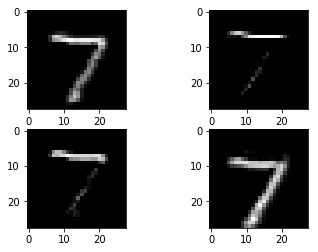

In [73]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(conv1_[0,:,:,0], cmap='gray')
ax[0, 1].imshow(conv1_[0,:,:,1], cmap='gray')
ax[1, 0].imshow(conv1_[0,:,:,2], cmap='gray')
ax[1, 1].imshow(conv1_[0,:,:,3], cmap='gray')

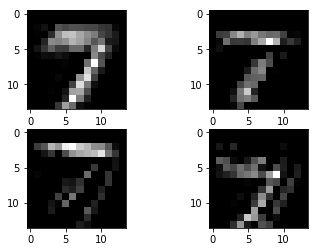

In [74]:
fig, ax = plt.subplots(2, 2)

ax[0, 0].imshow(conv2_[0,:,:,0], cmap='gray')
ax[0, 1].imshow(conv2_[0,:,:,1], cmap='gray')
ax[1, 0].imshow(conv2_[0,:,:,2], cmap='gray')
ax[1, 1].imshow(conv2_[0,:,:,3], cmap='gray')

In [ ]:
|